tobac example: Tracking isolated convection based on updraft velocity and total condensate
==

This example notebook demonstrates the use of tobac to track isolated deep convective clouds in cloud-resolving model simulation output based on vertical velocity and total condensate mixing ratio.

The simulation results used in this example were performed as part of the ACPC deep convection intercomparison  case study (http://acpcinitiative.org/Docs/ACPC_DCC_Roadmap_171019.pdf) with WRF using the Morrison microphysics scheme. 

The data used in this example is downloaded from "zenodo link" automatically as part of the notebooks (This only has to be done once for all the tobac example notebooks).

**Import libraries:**

In [10]:
import xarray
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
from six.moves import urllib
import shutil
from glob import glob
%matplotlib inline

In [2]:
# Import tobac itself:
import tobac

In [3]:
#Disable a couple of warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)


**Download and load example data:**   
The actual dowloading is only necessary once for all example notebooks.

In [4]:
data_out='../'

In [11]:
# Download the data: This only has to be done once for all tobac examples and can take a while
file_path='https://zenodo.org/record/3195910/files/climate-processes/tobac_example_data-v1.0.1.zip'
#file_path='http://zenodo..'
tempfile='temp.zip'
print('start downloading data')
request=urllib.request.urlretrieve(file_path,tempfile)
print('start extracting data')
shutil.unpack_archive(tempfile,data_out)
# zf = zipfile.ZipFile(tempfile)
# zf.extractall(data_out)
os.remove(tempfile)
print('data extracted')


start downloading data
start extracting data
data extracted


**Load Data from downloaded file:**

In [12]:
data_file_W_mid_max = os.path.join(data_out,'*','data','Example_input_midlevelUpdraft.nc')
data_file_W_mid_max = glob(data_file_W_mid_max)[0]
data_file_TWC = os.path.join(data_out,'*','data','Example_input_Condensate.nc')
data_file_TWC = glob(data_file_TWC)[0]

In [18]:
W_mid_max=xarray.open_dataset(data_file_W_mid_max)['w']
TWC=xarray.open_dataset(data_file_TWC)['twc']

In [20]:
# Display information about the two cubes for vertical velocity and total condensate mixing ratio:
display(W_mid_max)
display(TWC)


<xarray.DataArray 'w' (time: 47, south_north: 198, west_east: 198)>
[1842588 values with dtype=float32]
Coordinates:
  * time                (time) datetime64[ns] 2013-06-19T20:05:00 ... 2013-06-19T23:55:00
  * south_north         (south_north) int64 281 282 283 284 ... 475 476 477 478
  * west_east           (west_east) int64 281 282 283 284 ... 475 476 477 478
    bottom_top_stag     int64 ...
    latitude            (south_north, west_east) float32 ...
    longitude           (south_north, west_east) float32 ...
    model_level_number  int64 ...
    x                   (west_east) float64 ...
    y                   (south_north) float64 ...
    x_0                 (west_east) int64 ...
    y_0                 (south_north) int64 ...
Attributes:
    long_name:     w
    units:         m s-1
    cell_methods:  model_level_number: maximum

<xarray.DataArray 'twc' (time: 47, bottom_top: 94, south_north: 198, west_east: 198)>
[173203272 values with dtype=float32]
Coordinates:
  * time                (time) datetime64[ns] 2013-06-19T20:05:00 ... 2013-06-19T23:55:00
  * bottom_top          (bottom_top) int64 0 1 2 3 4 5 6 ... 88 89 90 91 92 93
  * south_north         (south_north) int64 281 282 283 284 ... 475 476 477 478
  * west_east           (west_east) int64 281 282 283 284 ... 475 476 477 478
    latitude            (south_north, west_east) float32 29.62032 ... 30.515106
    longitude           (south_north, west_east) float32 -94.90857 ... -93.863464
    model_level_number  (bottom_top) int64 0 1 2 3 4 5 6 ... 88 89 90 91 92 93
    x                   (west_east) float64 1.408e+05 1.412e+05 ... 2.392e+05
    y                   (south_north) float64 1.408e+05 1.412e+05 ... 2.392e+05
    x_0                 (west_east) int64 281 282 283 284 ... 475 476 477 478
    y_0                 (south_north) int64 281 282 283 284 ... 475 476 477 478
Attributes:
    long_name:  TWC
    units:      kg kg-1

In [21]:
#Set up directory to save output and plots:
savedir='Save'
if not os.path.exists(savedir):
    os.makedirs(savedir)
plot_dir="Plot"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

**Feature detection:**

Perform feature detection based on midlevel maximum vertical velocity and a range of threshold values.

In [22]:
# Determine temporal and spatial sampling of the input data:
dxy,dt=tobac.utils.get_spacings(W_mid_max)

(<xarray.DataArray 'w' (time: 47, south_north: 198, west_east: 198)>
[1842588 values with dtype=float32]
Coordinates:
  * time                (time) datetime64[ns] 2013-06-19T20:05:00 ... 2013-06-19T23:55:00
  * south_north         (south_north) int64 281 282 283 284 ... 475 476 477 478
  * west_east           (west_east) int64 281 282 283 284 ... 475 476 477 478
    bottom_top_stag     int64 39
    latitude            (south_north, west_east) float32 29.62032 ... 30.515106
    longitude           (south_north, west_east) float32 -94.90857 ... -93.863464
    model_level_number  int64 39
    x                   (west_east) float64 1.408e+05 1.412e+05 ... 2.392e+05
    y                   (south_north) float64 1.408e+05 1.412e+05 ... 2.392e+05
    x_0                 (west_east) int64 281 282 283 284 ... 475 476 477 478
    y_0                 (south_north) int64 281 282 283 284 ... 475 476 477 478
Attributes:
    long_name:     w
    units:         m s-1
    cell_methods:  model_level_n

In [23]:
# Keyword arguments for feature detection step:
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=0.5
parameters_features['min_num']=3
parameters_features['min_distance']=0
parameters_features['sigma_threshold']=1
parameters_features['threshold']=[3,5,10] #m/s
parameters_features['n_erosion_threshold']=0
parameters_features['n_min_threshold']=3

In [25]:
# Perform feature detection and save results:
print('start feature detection based on midlevel column maximum vertical velocity')
dxy,dt=tobac.utils.get_spacings(W_mid_max)
Features=tobac.themes.tobac_v1.feature_detection_multithreshold(W_mid_max,dxy,**parameters_features)
print('feature detection performed start saving features')
Features.to_netcdf(os.path.join(savedir,'Features.nc'))
print('features saved')


start feature detection based on midlevel column maximum vertical velocity
(<xarray.DataArray 'w' (time: 47, south_north: 198, west_east: 198)>
array([[[ 9.526741e-02,  9.635128e-02, ...,  1.212678e-01,  1.705124e-01],
        [ 8.655177e-02,  7.846846e-02, ...,  1.329186e-01,  2.395868e-01],
        ...,
        [ 4.878530e-02,  1.035132e-01, ...,  9.615456e-02,  3.050198e-01],
        [ 1.666172e-01,  1.892146e-01, ...,  1.208665e-01,  3.202891e-02]],

       [[ 2.121310e-01,  2.363261e-01, ...,  1.160719e-01,  9.372611e-02],
        [ 2.313648e-01,  2.486266e-01, ...,  8.350717e-02,  4.215705e-02],
        ...,
        [ 1.138031e-01,  1.837625e-01, ...,  3.983918e-02,  7.152132e-02],
        [ 1.865201e-01,  2.180458e-01, ...,  5.887938e-02,  1.261164e-01]],

       ...,

       [[ 1.378807e-01,  2.798423e-02, ...,  1.759233e-01,  1.753576e-01],
        [ 1.585422e-01, -4.061365e-04, ...,  1.445557e-01,  1.606891e-01],
        ...,
        [ 8.781905e-01,  8.803757e-01, ...,  8.683

**Segmentation:**  
Perform segmentation based on 3D total condensate field to determine cloud volumes associated to identified features:

In [26]:
parameters_segmentation_TWC={}
parameters_segmentation_TWC['method']='watershed'
parameters_segmentation_TWC['threshold']=0.1e-3  # kg/kg mixing ratio

In [28]:
print('Start segmentation based on total water content')
Mask_TWC,Features_TWC=tobac.themes.tobac_v1.segmentation(Features,TWC,dxy,**parameters_segmentation_TWC)
print('segmentation TWC performed, start saving results to files')
Mask_TWC.to_netcdf(os.path.join(savedir,'Mask_Segmentation_TWC.nc'))
Features_TWC.to_netcdf(os.path.join(savedir,'Features_TWC.nc'))
print('segmentation TWC performed and saved')

Start segmentation based on total water content
<xarray.DataArray 'twc' (time: 47, bottom_top: 94, south_north: 198, west_east: 198)>
[173203272 values with dtype=float32]
Coordinates:
  * time                (time) datetime64[ns] 2013-06-19T20:05:00 ... 2013-06-19T23:55:00
  * bottom_top          (bottom_top) int64 0 1 2 3 4 5 6 ... 88 89 90 91 92 93
  * south_north         (south_north) int64 281 282 283 284 ... 475 476 477 478
  * west_east           (west_east) int64 281 282 283 284 ... 475 476 477 478
    latitude            (south_north, west_east) float32 29.62032 ... 30.515106
    longitude           (south_north, west_east) float32 -94.90857 ... -93.863464
    model_level_number  (bottom_top) int64 0 1 2 3 4 5 6 ... 88 89 90 91 92 93
    x                   (west_east) float64 1.408e+05 1.412e+05 ... 2.392e+05
    y                   (south_north) float64 1.408e+05 1.412e+05 ... 2.392e+05
    x_0                 (west_east) int64 281 282 283 284 ... 475 476 477 478
    y_0    

**Trajectory linking:**  
Detected features are linked into cloud trajectories using the trackpy library (http://soft-matter.github.io/trackpy). This takes the feature positions determined in the feature detection step into account but does not include information on the shape of the identified objects.

In [29]:
# Keyword arguments for linking step:
parameters_linking={}
parameters_linking['method_linking']='predict'
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=0
parameters_linking['order']=1
parameters_linking['subnetwork_size']=100
parameters_linking['memory']=0
parameters_linking['time_cell_min']=5*60
parameters_linking['method_linking']='predict'
parameters_linking['v_max']=10
parameters_linking['d_min']=2000


In [31]:
# Perform linking and save results:
Track=tobac.themes.tobac_v1.linking_trackpy(Features,W_mid_max,dt=dt,dxy=dxy,**parameters_linking)
Track.to_netcdf(os.path.join(savedir,'Track.nc'))


Frame 46: 18 trajectories present.


**Visualisation:**  

In [32]:
# Set extent for maps plotted in the following cells ( in the form [lon_min,lon_max,lat_min,lat_max])
axis_extent=[-95,-93.8,29.5,30.6]        

(<xarray.Dataset>
Dimensions:                  (index: 629)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 ... 624 625 626 627 628
Data variables:
    frame                    (index) int64 0 0 0 0 0 0 0 ... 46 46 46 46 46 46
    idx                      (index) int64 3 6 8 12 14 15 ... 35 36 38 39 40 41
    hdim_1                   (index) float64 86.77 109.6 116.8 ... 186.8 190.4
    hdim_2                   (index) float64 53.35 65.23 191.2 ... 102.0 179.8
    num                      (index) int64 10 7 6 5 43 17 11 ... 69 51 6 53 17 4
    threshold_value          (index) int64 3 3 3 3 5 5 5 ... 5 10 10 10 10 10 10
    feature                  (index) int64 1 2 3 4 5 6 ... 625 626 627 628 629
    time                     (index) object 2013-06-19 20:05:00 ... 2013-06-19 23:55:00
    timestr                  (index) object '2013-06-19 20:05:00' ... '2013-06-19 23:55:00'
    south_north              (index) float64 367.8 390.6 397.8 ... 467.8 471.4
    west_east  

TypeError: dropna() missing 1 required positional argument: 'dim'

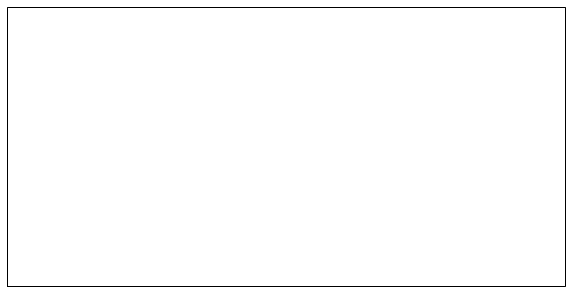

In [33]:
# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})
ax_map=tobac.plot.map_tracks(Track,axis_extent=axis_extent,axes=ax_map)

In [34]:
# Create animation showing tracked cells with outline of cloud volumes and the midlevel vertical velocity as a background field:
animation_tobac=tobac.plot.animation_mask_field(track=Track,features=Features,field=W_mid_max,mask=Mask_TWC,
                                          axis_extent=axis_extent,#figsize=figsize,orientation_colorbar='horizontal',pad_colorbar=0.2,
                                          vmin=0,vmax=20,extend='both',cmap='Blues',
                                          interval=500,figsize=(10,7),
                                          plot_outline=True,plot_marker=True,marker_track='x',plot_number=True,plot_features=True)

()
{'track': <xarray.Dataset>
Dimensions:                  (index: 629)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 ... 624 625 626 627 628
Data variables:
    frame                    (index) int64 0 0 0 0 0 0 0 ... 46 46 46 46 46 46
    idx                      (index) int64 3 6 8 12 14 15 ... 35 36 38 39 40 41
    hdim_1                   (index) float64 86.77 109.6 116.8 ... 186.8 190.4
    hdim_2                   (index) float64 53.35 65.23 191.2 ... 102.0 179.8
    num                      (index) int64 10 7 6 5 43 17 11 ... 69 51 6 53 17 4
    threshold_value          (index) int64 3 3 3 3 5 5 5 ... 5 10 10 10 10 10 10
    feature                  (index) int64 1 2 3 4 5 6 ... 625 626 627 628 629
    time                     (index) object 2013-06-19 20:05:00 ... 2013-06-19 23:55:00
    timestr                  (index) object '2013-06-19 20:05:00' ... '2013-06-19 23:55:00'
    south_north              (index) float64 367.8 390.6 397.8 ... 467.8 471.4
   

AttributeError: 'DataArray' object has no attribute 'coord'

In [35]:
# Display animation:
from IPython.display import HTML, Image, display
HTML(animation_tobac.to_html5_video())

NameError: name 'animation_tobac' is not defined

In [ ]:
# # Save animation to file 
# savefile_animation=os.path.join(plot_dir,'Animation.mp4')
# animation_tobac.save(savefile_animation,dpi=200)
# print(f'animation saved to {savefile_animation}')

(<xarray.Dataset>
Dimensions:                  (index: 629)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 ... 624 625 626 627 628
Data variables:
    frame                    (index) int64 0 0 0 0 0 0 0 ... 46 46 46 46 46 46
    idx                      (index) int64 3 6 8 12 14 15 ... 35 36 38 39 40 41
    hdim_1                   (index) float64 86.77 109.6 116.8 ... 186.8 190.4
    hdim_2                   (index) float64 53.35 65.23 191.2 ... 102.0 179.8
    num                      (index) int64 10 7 6 5 43 17 11 ... 69 51 6 53 17 4
    threshold_value          (index) int64 3 3 3 3 5 5 5 ... 5 10 10 10 10 10 10
    feature                  (index) int64 1 2 3 4 5 6 ... 625 626 627 628 629
    time                     (index) object 2013-06-19 20:05:00 ... 2013-06-19 23:55:00
    timestr                  (index) object '2013-06-19 20:05:00' ... '2013-06-19 23:55:00'
    south_north              (index) float64 367.8 390.6 397.8 ... 467.8 471.4
    west_east  

TypeError: 'DatasetGroupBy' object is not subscriptable

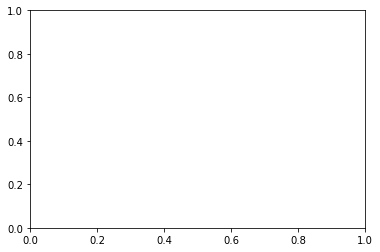

In [36]:
# Updraft lifetimes of tracked cells:
fig_lifetime,ax_lifetime=plt.subplots()
tobac.plot.plot_lifetime_histogram_bar(Track,axes=ax_lifetime,bin_edges=np.arange(0,120,10),density=False,width_bar=8)
ax_lifetime.set_xlabel('lifetime (min)')
ax_lifetime.set_ylabel('counts')
         